In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

In [10]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': '######', # пароль
    'host': '#####',
    'port': #####, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
} 

In [11]:
connection_string = 'postgresql://praktikum_student:LINK_DELETED/data-analyst-advanced-sql'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [12]:
engine = create_engine(connection_string) 

In [13]:
query = '''
WITH profile AS
  (SELECT user_id,
          dt,
          COUNT(*) OVER (PARTITION BY dt) AS cohort_users_cnt
   FROM online_store.profiles
   WHERE channel = 'Organic'),
sessions AS 
(SELECT user_id,
        session_start::date AS session_date
FROM online_store.sessions
GROUP BY 1,
         2)
SELECT p.dt AS cohort_dt,
       session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4
'''

In [14]:
retention_rate_df = pd.read_sql_query(query, con = engine) 

In [15]:
print(retention_rate_df.head()) 

    cohort_dt session_date  users_cnt  cohort_users_cnt  retention_rate
0  2020-06-14   2020-06-14       5098              5098          100.00
1  2020-06-14   2020-06-15       2647              5098           51.92
2  2020-06-14   2020-06-16       1836              5098           36.01
3  2020-06-14   2020-06-17       1403              5098           27.52
4  2020-06-14   2020-06-18       1085              5098           21.28


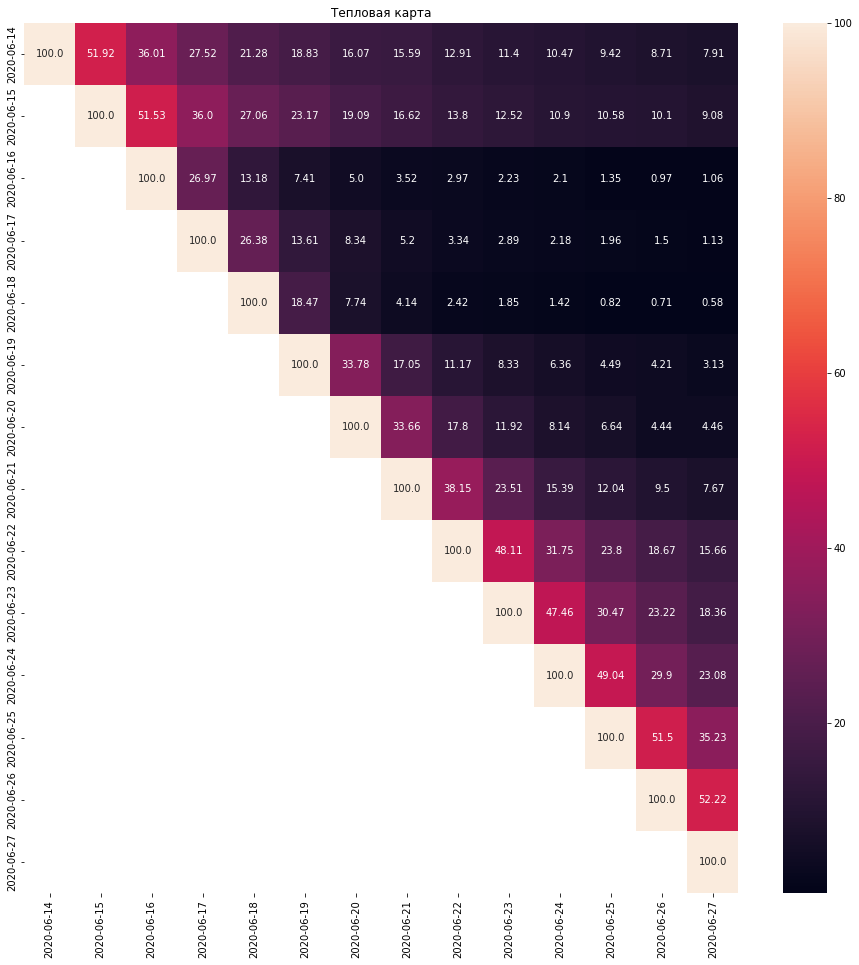

In [16]:
# создаём сводную таблицу с результатами
retention = retention_rate_df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

In [17]:
query = '''
WITH profile AS
  (SELECT u.user_id,
          DATE_TRUNC('month', MIN(event_time))::date AS start_mn
   FROM tools_shop.users u
   JOIN tools_shop.orders o ON u.user_id = o.user_id
   JOIN tools_shop.events e ON u.user_id = e.user_id
   GROUP BY 1), 
sessions AS
  (SELECT start_mn,
          DATE_TRUNC('month', event_time)::date AS event_mn,
          COUNT(DISTINCT p.user_id) AS users_cnt
   FROM profile p
   JOIN tools_shop.events e ON p.user_id = e.user_id
   GROUP BY 1,
            2)
SELECT start_mn,
       event_mn,
       users_cnt,
       LAG(users_cnt) OVER (PARTITION BY start_mn ORDER BY event_mn) AS previous_day_users_cnt,
       ROUND((1 - (users_cnt::numeric / LAG(users_cnt) OVER (PARTITION BY start_mn ORDER BY event_mn))) * 100, 2) AS churn_rate
FROM sessions
WHERE start_mn BETWEEN '2018-01-01' AND '2018-06-01'
  AND event_mn BETWEEN '2018-01-01' AND '2018-12-01'; 
'''

In [18]:
churn_rate_df = pd.read_sql_query(query, con = engine) 

In [20]:
print(churn_rate_df.head(10))

     start_mn    event_mn  users_cnt  previous_day_users_cnt  churn_rate
0  2018-01-01  2018-01-01        257                     NaN         NaN
1  2018-01-01  2018-02-01         67                   257.0       73.93
2  2018-01-01  2018-03-01         41                    67.0       38.81
3  2018-01-01  2018-04-01         44                    41.0       -7.32
4  2018-01-01  2018-05-01         42                    44.0        4.55
5  2018-01-01  2018-06-01         21                    42.0       50.00
6  2018-01-01  2018-07-01         11                    21.0       47.62
7  2018-01-01  2018-08-01          3                    11.0       72.73
8  2018-02-01  2018-02-01        226                     NaN         NaN
9  2018-02-01  2018-03-01         59                   226.0       73.89


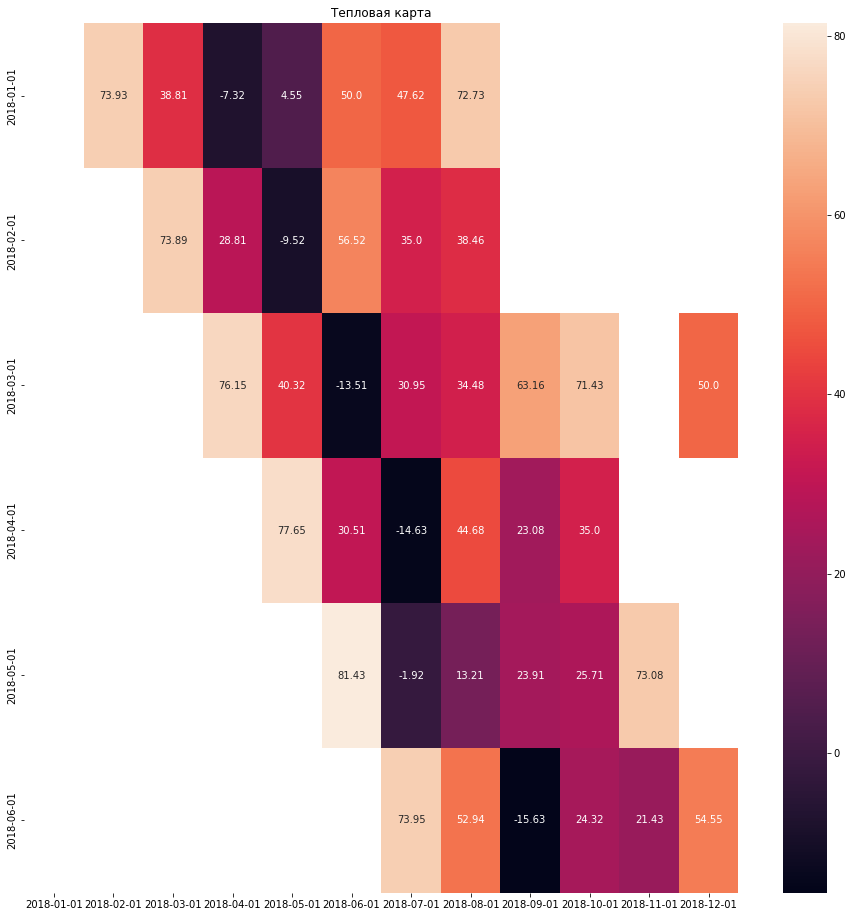

In [21]:
# создаём сводную таблицу с результатами
churn = churn_rate_df.pivot('start_mn', 'event_mn', 'churn_rate')
churn.index = [str(x)[0:10] for x in churn.index]
churn.columns = [str(x)[0:10] for x in churn.columns]

# строим хитмэп
plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(churn, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

In [22]:
churn

,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
2018-01-01,NaN,73.93,38.81,-7.32,4.55,50.00,47.62,72.73,NaN,NaN,NaN,NaN
2018-02-01,NaN,NaN,73.89,28.81,-9.52,56.52,35.00,38.46,NaN,NaN,NaN,NaN
2018-03-01,NaN,NaN,NaN,76.15,40.32,-13.51,30.95,34.48,63.16,71.43,NaN,50.00
2018-04-01,NaN,NaN,NaN,NaN,77.65,30.51,-14.63,44.68,23.08,35.00,NaN,NaN
2018-05-01,NaN,NaN,NaN,NaN,NaN,81.43,-1.92,13.21,23.91,25.71,73.08,NaN
2018-06-01,NaN,NaN,NaN,NaN,NaN,NaN,73.95,52.94,-15.63,24.32,21.43,54.55
